In [239]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from dendrogram_weights import get_dendrogram_weights
from sklearn import decomposition
import math
import numpy as np
import pandas as pd
from sklearn import datasets, decomposition, metrics
from matplotlib import pyplot as plt
from hierarchy import dist, merge, calc_partitions, calc_dists
import copy

In [388]:
reload(general_htsne)
from general_htsne import g_htsne

In [364]:
# for late exaggeration, basically turns off early exaggeration and set the initial values the result of the htsne output
def modified_tsne(x_init, htsne_result, labels, iterations=200, random_state=1000, save_name = None):
    
    def perplex_helper(Di, sigma):
        Pi = np.exp(-1*Di.copy() * sigma)
        Psum = np.sum(Pi)
        perp_calc = np.log(Psum) + sigma * np.sum(Di * Pi) / Psum
        Pf = Pi/Psum
        return Pf, perp_calc


    def calc_p_vals(X, tol = 1e-5, perplexity = 30.0):
        (n, d) = X.shape
        partitions, pdist = calc_partitions(X, dist)
        pdists = pdist[0]
        P = np.zeros((n,n))
        sigmas = np.ones((n,1))

        for i in range(n):
            Di = pdists[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
            Pf, perp_calc = perplex_helper(Di, sigmas[i])
            #perplexity calculation - binary search for best param
            min_ = -np.inf
            max_ = np.inf
            count = 0
            diff = perp_calc - np.log(perplexity)
            while diff > tol and count < 50:
                if diff > 0:
                    min_ = sigmas[i].copy()
                    if max_ == np.inf or max_ == -np.inf:
                        sigmas[i] = sigmas[i] * 2.
                    else:
                        sigmas[i] = (sigmas[i] + max_) / 2.
                else:
                    max_ = sigmas[i].copy()
                    if min_ == np.inf or min_ == -np.inf:
                        sigmas[i] = sigmas[i] / 2.
                    else:
                        sigmas[i] = (sigmas[i] + min_) / 2.
                count+=1
                Pf, perp_calc = perplex_helper(Di, sigmas[i])
                diff = perp_calc - np.log(perplexity)

            P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = Pf

        return P
    

    random_state = 1000
    np.random.seed(random_state)

    y = htsne_result
    x = x_init



    #PCA and normalize into ball of radius 1
    x = decomposition.PCA(n_components=30).fit_transform(x_init)
    x = x/np.var(np.linalg.norm(x, axis=1))
    (n,d) = x.shape

    pvals  = calc_p_vals(x)

    pvals = pvals + pvals.T       # calculate symmetric pvals
    pvals = pvals / np.sum(pvals)

#     #early exaggeration
#     pvals = pvals * 4.
    pvals = np.maximum(pvals, 1e-12)

    #gradient descent params
    dy = np.zeros((n,2))
    lr = 50

    # params for van der maaten's momentum magic!
    prev_y = np.zeros((n,2))
    init_momentum = 0.5
    st_momentum = 0.8
    gains = np.ones((n, 2))
    min_gain = 0.01
    eta = 500

    print('Preprocessing done...\n\n')
    for iter in range(iterations):


        #qvals for first layer -> computation trick from van der maaten's code
        sum_Y = np.sum(np.square(y), 1)
        num = -2. * np.dot(y, y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        qvals = num / np.sum(num)
        qvals = np.maximum(qvals, 1e-12)

        #compute gradient -> computation trick again stolen from van der maaten
        PQ = pvals - qvals
        for i in range(n):
            dy[i,:] = np.sum(np.tile(PQ[:, i] * num[:, i], (2, 1)).T * (y[i, :] - y), 0)

        # van der maaten's momentum magic
        # if iter < 20:
        #     momentum = init_momentum
        # else:
        #     momentum = st_momentum
        # gains = (gains + 0.2) * ((dy > 0.) != (iy > 0.)) + \
        #         (gains * 0.8) * ((dy > 0.) == (iy > 0.))
        # gains[gains < min_gain] = min_gain
        # iy = momentum * iy - eta * (gains * dy)
        # y = y + iy
        # y = y - np.tile(np.mean(y, 0), (n, 1))

        #our shitty gd implementation
        y = y-lr*dy

        #print loss value
        if (iter + 1) % 100 == 0:
            L = np.sum(pvals * np.log(pvals / qvals))  #KL divergence
            print("Iteration %d: error is %f" % (iter + 1, L))

#         #stop early exaggeration
#         if iter == 100:
#             pvals = pvals/4
    desired_classes = np.unique(labels)
    

    try:
        if(save_name is not None):
            np.savetxt(save_name + "_y.csv", y, delimiter = ',')
            np.savetxt(save_name + "_labels.csv", labels, delimiter = ',')
        plt.figure()
        base = {}
        for class_ in desired_classes:
            base[class_] = []
        _dict = copy.deepcopy(base)
        for i,row in enumerate(y):
            _dict[labels[i]].append(row)
        for i in _dict.keys():
            plt.scatter(np.array(_dict[i])[:,0], np.array(_dict[i])[:,1], alpha=0.6)
        plt.legend(desired_classes)
    except Exception as e:
        print(e)
        plt.scatter(y[:,0], y[:,1], alpha=0.2)
        
    plt.axis('equal')
    if(save_name is not None):
        plt.savefig(save_name + '.png')
    plt.show()
    
    plt.figure()

    plt.plot(list(ixds.keys()), list(ixds.values()))
    if (save_name is not None):
        plt.savefig(save_name + '_fm_idx_tsne.png')
    plt.show()
    return y

In [25]:
def plot_blobs(X, y):
    plt.axis("equal")
    labels = np.unique(y)
    plt.grid(True)
    for label in labels:
        plt.scatter(X[y==label][:,0], X[y==label][:,1])
    plt.show()
        

In [12]:
def make_asymmetric_blobs (x_dist, y_dist,std, samples, dims):
    zeros = [0] * 98
    X, y = make_blobs(n_samples=samples,
                      n_features=dims, centers=[[-x_dist/2,0]+zeros, [x_dist/2,0]+zeros,
                      [0,y_dist]+zeros], cluster_std=std, shuffle=True, random_state=100)
    plt.scatter(X[y==0][:,0], X[y==0][:,1])
    plt.scatter(X[y==1][:,0], X[y==1][:,1])
    plt.scatter(X[y==2][:,0], X[y==2][:,1])
    plt.axis('equal')
    plt.grid('true')
    plt.show()
    
    return X, y





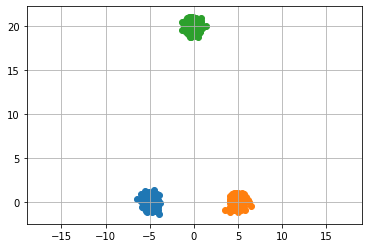

In [89]:
X, y = make_asymmetric_blobs(10,20,0.5 ,500, 100)

In [376]:
from importlib import reload 
import general_tsne
from general_tsne import g_tsne

Preprocessing done...


Iteration 100: error is 15.240360
Iteration 200: error is 2.304370
Iteration 300: error is 2.157025
Iteration 400: error is 1.997614
Iteration 500: error is 1.921258
Weighted Adjusted Rand Index: 0.9842982745438223
Morlini-Zani Index: 0.6525888612983327


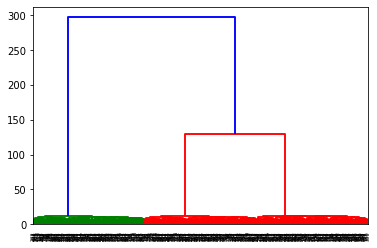

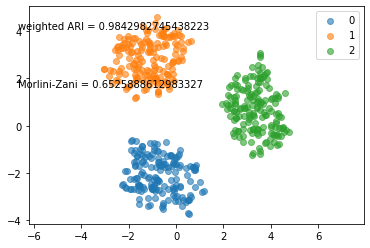

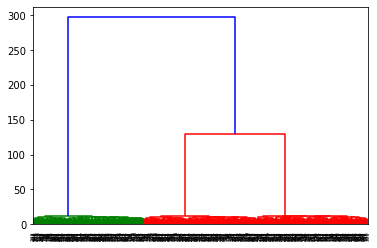

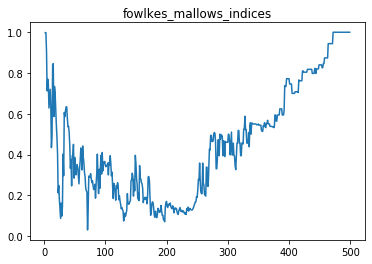

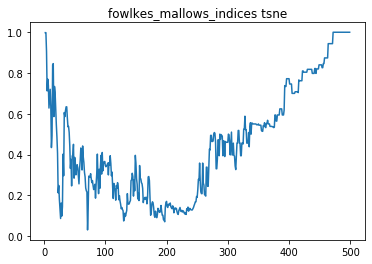

array([[-2.64042005e+00,  2.28995388e+00],
       [ 4.43832698e+00, -9.22418597e-02],
       [-1.50167267e-01,  1.99136222e+00],
       [ 3.81817809e+00, -6.67672231e-01],
       [-5.98688653e-01,  3.80461617e+00],
       [-6.55417297e-02,  3.89755012e+00],
       [ 3.52795203e+00,  9.33407144e-01],
       [-2.06636111e+00, -1.93151408e+00],
       [ 3.41715474e+00, -1.56031038e-01],
       [ 2.82325492e-01,  3.27943007e+00],
       [-2.79136052e+00,  2.34565563e+00],
       [-6.73610416e-03, -1.34352848e+00],
       [-1.18427602e+00,  3.10302076e+00],
       [ 4.26066445e+00, -3.59106145e-01],
       [ 4.93917729e-01, -3.15003866e+00],
       [ 4.18958653e+00,  1.19094742e+00],
       [-1.19853269e-01, -1.58828903e+00],
       [ 3.23605783e+00, -1.18044452e-01],
       [ 2.42799608e-03, -1.59915104e+00],
       [-1.64253116e+00,  1.99567746e+00],
       [-5.46991045e-01,  3.91810652e+00],
       [-1.58301111e+00,  2.59331415e+00],
       [-1.95510421e+00, -2.24166477e+00],
       [-1.

In [18]:
g_tsne(X,y, save_name="3_blob_2_close_1_far_500_pts", iterations=500)

In [86]:
tsne_result = np.genfromtxt("./3_blob_2_close_1_far/3_blob_2_close_1_far_500_pts_y.csv", delimiter=",")

array([8.95098995e-03, 7.81956538e-01, 7.16868165e-03, 6.17536870e-03,
       3.10533811e-02, 8.78037553e-03, 2.11141576e-03, 4.48194176e-02,
       6.96259258e-03, 2.73832098e-03, 1.34299070e-02, 2.98713660e-03,
       5.70223049e-03, 6.62964006e-03, 5.21850150e-03, 2.42143169e-03,
       6.06278169e-03, 2.73156091e-04, 3.55307106e-03, 7.56619501e-03,
       1.17165062e-03, 8.38516874e-04, 1.32885408e-04, 1.00019009e-04,
       5.37305271e-04, 4.19907777e-03, 1.35791077e-04, 1.01108888e-03,
       2.73981606e-03, 7.71380324e-04, 1.58277864e-05, 1.49661813e-03,
       6.83003064e-05, 8.19938323e-04, 8.21314939e-04, 4.61449561e-04,
       1.73677668e-04, 2.64491850e-03, 3.50031071e-04, 7.26743292e-04,
       1.09047709e-03, 2.21598169e-03, 1.16427071e-03, 3.76297496e-04,
       1.27322211e-04, 4.34957510e-04, 7.65500387e-04, 1.01107334e-04,
       3.13565067e-04, 1.86003970e-04, 8.34872651e-05, 1.61942546e-04,
       6.64825729e-04, 1.70752408e-04, 2.06669686e-04, 6.76242108e-04,
      

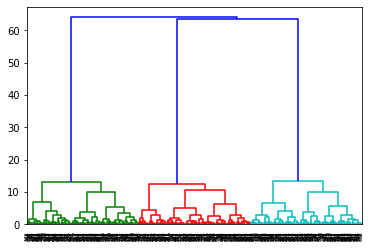

In [87]:
get_dendrogram_weights(tsne_result)

In [378]:
from general_htsne import g_htsne
import general_htsne

dumping pvals and partitions
Preprocessing done...


Iteration 10: error is 1931.474846
Iteration 20: error is 1928.239010
Iteration 30: error is 1916.177465
Iteration 40: error is 1877.857946
Iteration 50: error is 1818.586045
Iteration 60: error is 1773.327014
Iteration 70: error is 1743.026002
Iteration 80: error is 1718.986778
Iteration 90: error is 1695.484620
Iteration 100: error is 1670.604559
Iteration 110: error is 1646.265479
Iteration 120: error is 1625.137829
Iteration 130: error is 1608.070061
Iteration 140: error is 1594.591269
Iteration 150: error is 1583.920556
Iteration 160: error is 1575.372352
Iteration 170: error is 1568.425956
Iteration 180: error is 1562.700821
Iteration 190: error is 1557.919672
Iteration 200: error is 1553.878490
Iteration 210: error is 1550.425034
Iteration 220: error is 1547.443997
Iteration 230: error is 1544.846804
Iteration 240: error is 1542.564522
Iteration 250: error is 1540.542879
Iteration 260: error is 1538.738700
Iteration 270: error

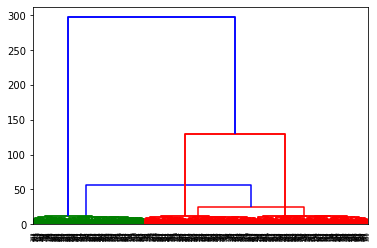

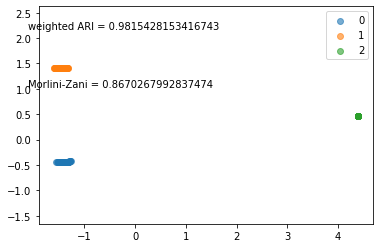

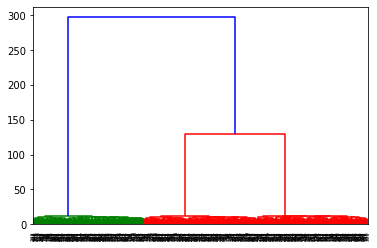

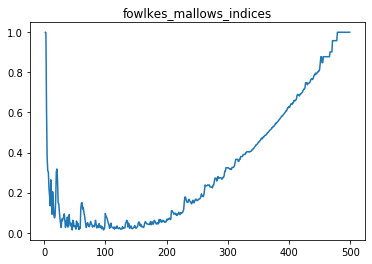

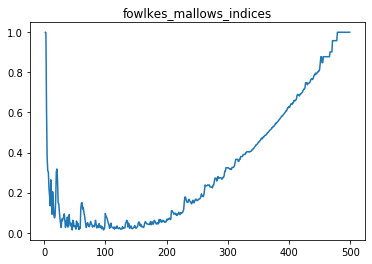

array([[-1.44839473,  1.41232259],
       [ 4.39271914,  0.47223237],
       [-1.33795156,  1.41492108],
       [ 4.39271911,  0.47223201],
       [-1.48358763,  1.41270966],
       [-1.49050561,  1.41256942],
       [ 4.39271912,  0.47223212],
       [-1.37760301, -0.43837533],
       [ 4.39271913,  0.47223225],
       [-1.35807219,  1.41586034],
       [-1.50432291,  1.41096386],
       [-1.46945913, -0.43742686],
       [-1.51165502,  1.41027409],
       [ 4.39271913,  0.47223242],
       [-1.37907385, -0.43703854],
       [ 4.39271913,  0.47223265],
       [-1.5107738 , -0.43859741],
       [ 4.39271913,  0.47223186],
       [-1.38642989, -0.43806431],
       [-1.35841829,  1.41510409],
       [-1.50780854,  1.41028798],
       [-1.38969787,  1.41480318],
       [-1.51324884, -0.43662943],
       [-1.364708  ,  1.41405758],
       [-1.55581686,  1.40721787],
       [-1.39406438, -0.43847851],
       [-1.44047188,  1.41377786],
       [-1.41553212, -0.43737152],
       [-1.40897933,

In [20]:
g_htsne(X,y, save_name="3_blob_2_close_1_far_500_pts", iterations=500)

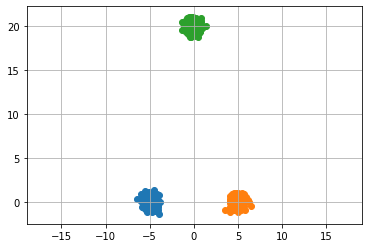

In [26]:
plot_blobs(X,y)

In [429]:

zeros = [0]*98
X, y = make_blobs(n_samples=500,
                  n_features=100, centers=[[-10/2,0]+zeros, [10/2,0]+zeros,
                  [0,20]+zeros, [13,20]+zeros, [40,10]+zeros], cluster_std=1, shuffle=True, random_state=100)

In [201]:
reload(hierarchy)
from hierarchy import dendrogram_norm

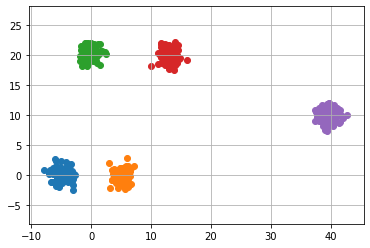

In [430]:
plot_blobs(X,y)

In [431]:
tsne_result = np.loadtxt("./5_cluster_house/5_cluster_house_500_pts_y.csv", delimiter=",")
htsne_result = np.load('./5_cluster_house/5_cluster_house_500_pts_htsne_data.npy')

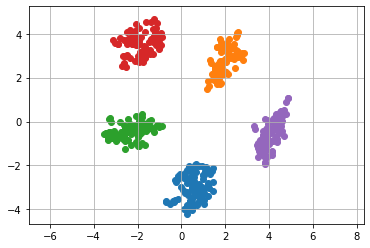

In [432]:
plot_blobs(tsne_result, y)

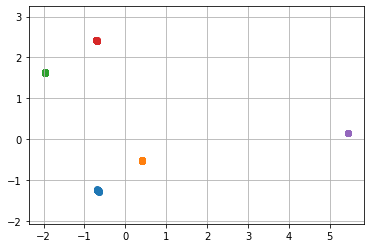

In [433]:
plot_blobs(htsne_result, y)

In [271]:
htsne_result[y==4]

array([[5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.43594683, 0.14558855],
       [5.

In [434]:
dendrogram_norm(X, tsne_result)

      fun: 100853.75267041504
 hess_inv: array([[0.00012496]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([5.245011])


100853.75267041504

In [435]:
dendrogram_norm(X, htsne_result)

      fun: 101636.08273180055
 hess_inv: array([[5.88026915e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([6.22438739])


101636.08273180055

Preprocessing done...


Iteration 100: error is 1.875531
Iteration 200: error is 1.777532
Iteration 300: error is 1.721495
Iteration 400: error is 1.655836


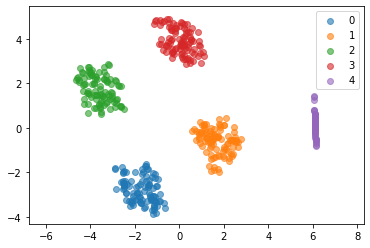

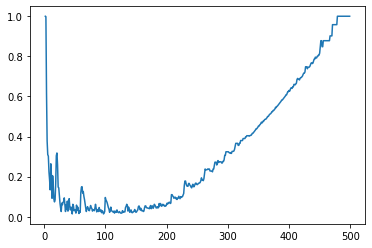

In [440]:
late_exaggerated = modified_tsne(X, htsne_result, y, iterations = 400)

In [441]:
print(dendrogram_norm(X, late_exaggerated))

      fun: 89564.353800354
 hess_inv: array([[3.03199585e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([4.55068845])
89564.353800354


In [411]:
zeros = [0]*98
X, y = make_blobs(n_samples=500,
                  n_features=100, centers=[[-5,0]+zeros, [10/2,0]+zeros,
                  [0,20]+zeros, [10,20]+zeros, [50,10]+zeros, [50,20]+zeros], cluster_std=1, shuffle=True, random_state=100)

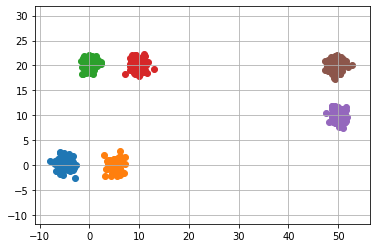

In [412]:
plot_blobs(X,y)

In [413]:
tsne_result = np.loadtxt("./6_clusters_hut/6_clusters_hut_500_pts_y.csv",
                        delimiter=",")
htsne_result = np.load("./6_clusters_hut/6_clusters_hut500_pts_htsne_data.npy")




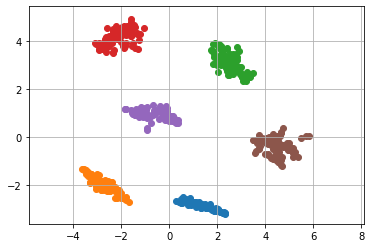

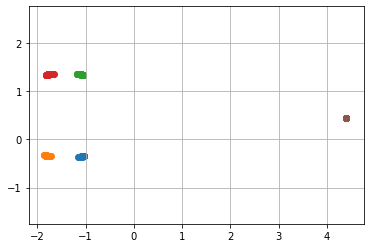

In [414]:
plot_blobs(tsne_result, y)

plot_blobs(htsne_result, y)

In [228]:
print(dendrogram_norm(X, tsne_result))

print(dendrogram_norm(X, htsne_result))

      fun: 218661.68434987243
 hess_inv: array([[3.75984786e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([6.03616263])
218661.68434987243
      fun: 115662.9793745361
 hess_inv: array([[6.18122496e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 8
   status: 0
  success: True
        x: array([8.52250352])
115662.9793745361


Preprocessing done...


Iteration 100: error is 1.867925
Iteration 200: error is 1.629261


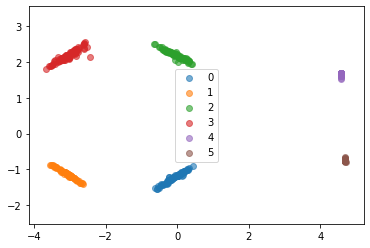

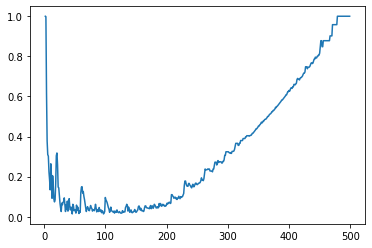

In [417]:
late_exagg = modified_tsne(X, htsne_result, y, iterations = 200)

In [419]:
print(dendrogram_norm(X, late_exagg))

      fun: 117963.79360389299
 hess_inv: array([[4.02002615e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([6.85949786])
117963.79360389299


In [230]:
zeros = [0]*98
X, y = make_blobs(n_samples=500,
                  n_features=100, centers=[[-5,0]+zeros, [10/2,0]+zeros,
                  [0,10]+zeros, [10,30]+zeros, [50,10]+zeros, [50,20]+zeros, [40,15]+zeros], cluster_std=1, shuffle=True, random_state=100)

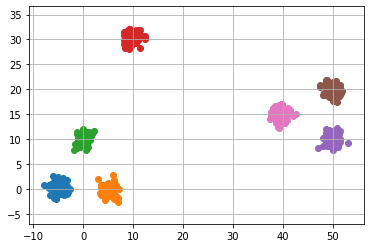

In [219]:
plot_blobs(X,y)

In [229]:
tsne_result = np.loadtxt("./7_cluster_motorcycle/7_clusters_motor_cycle_500_pts_y.csv",
                        delimiter=",")
htsne_result = np.load("./7_cluster_motorcycle/7_clusters_motor_cycle_500_pts_htsne_data.npy")




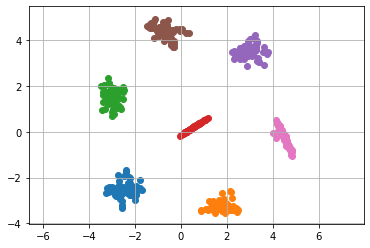

In [221]:
plot_blobs(tsne_result, y)

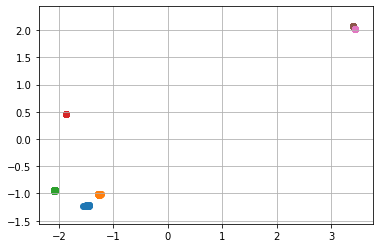

In [232]:
plot_blobs(htsne_result, y)

Preprocessing done...


Iteration 100: error is 3.718745
Iteration 200: error is 3.299150


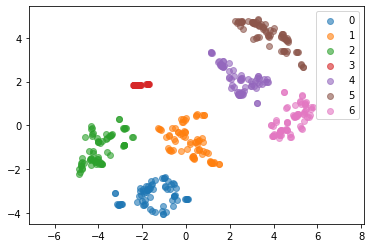

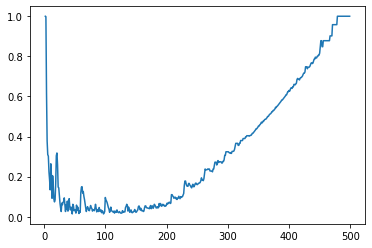

In [248]:
late_exaggerated = modified_tsne(X, htsne_result, y, iterations = 200)

In [223]:
print(dendrogram_norm(X, tsne_result))

print(dendrogram_norm(X, htsne_result))

      fun: 208578.19160083873
 hess_inv: array([[3.61341302e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 3
     njev: 6
   status: 0
  success: True
        x: array([5.98584783])
208578.19160083873
      fun: 148584.51103692275
 hess_inv: array([[5.89057122e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([8.0918766])
148584.51103692275


In [249]:
print(dendrogram_norm(X, late_exaggerated))

      fun: 112007.80004166355
 hess_inv: array([[3.36946317e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([6.31816354])
112007.80004166355


In [420]:
zeros = [0]*98
X, y = make_blobs(n_samples=500,
                  n_features=100, centers=[[-5,0]+zeros, [10/2,0]+zeros,
                  [0,10]+zeros, [10,30]+zeros, [50,10]+zeros, [50,20]+zeros, [40,15]+zeros, [25,15,100]+zeros[:-1]], cluster_std=4, shuffle=True, random_state=100)

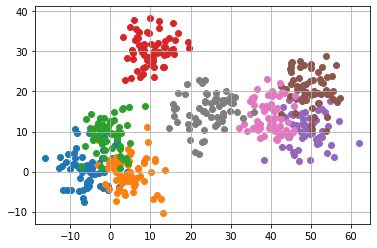

In [421]:
plot_blobs(X,y)

In [422]:
tsne_result = np.loadtxt("./8_lusters_1_close_highspread_500_pts/8_clusters_1_close_to_viewer_highspread_500_pts_y.csv",
                        delimiter=",")

In [423]:
htsne_result = np.load("./8_lusters_1_close_highspread_500_pts/8_clusters_1_close_to_viewer_highspread_500_pts_htsne_data.npy")

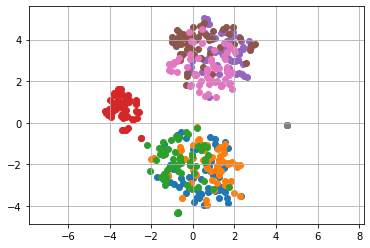

In [424]:
plot_blobs(tsne_result, y)

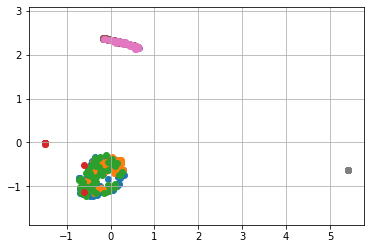

In [425]:
plot_blobs(htsne_result, y)

Preprocessing done...


Iteration 100: error is 2.039066


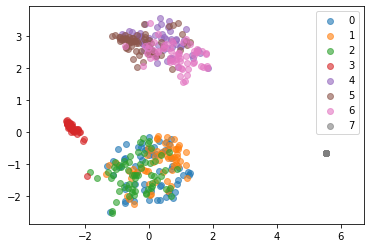

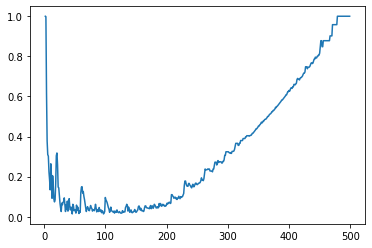

In [427]:
late_exagg = modified_tsne(X, htsne_result, y, iterations = 100)

In [428]:
print(dendrogram_norm(X, tsne_result))

print(dendrogram_norm(X, htsne_result))
print(dendrogram_norm(X, late_exagg))

      fun: 1355539.946824107
 hess_inv: array([[4.53001035e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([12.96265338])
1355539.946824107
      fun: 1512608.451001246
 hess_inv: array([[5.24156508e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([17.22198749])
1512608.451001246
      fun: 1401863.4751510103
 hess_inv: array([[3.80690994e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([15.14824946])
1401863.4751510103


In [312]:
X = np.load("../cnn_postprocessed.csv.npy")

In [313]:
y = np.load("../cnn_labels.csv.npy")

In [275]:
np.save("inet_permutations", indices)

In [74]:
indices = np.random.permutation(X.shape[0])

In [75]:
indices = indices[:500]

In [314]:
X, y = X[indices], y[indices]

Preprocessing done...


Iteration 100: error is 15.896479
Iteration 200: error is 2.054744
Iteration 300: error is 1.825161
Iteration 400: error is 1.689834
Iteration 500: error is 1.596877
Weighted Adjusted Rand Index: 0.7013164691829403
Morlini-Zani Index: 0.5380758698695121


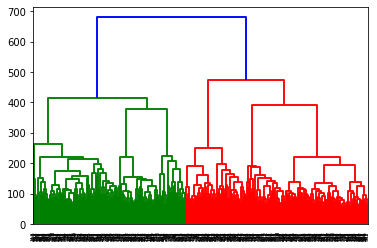

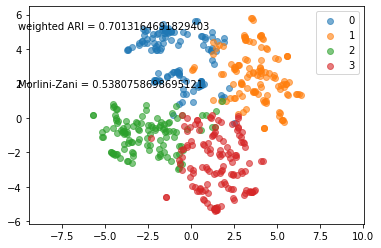

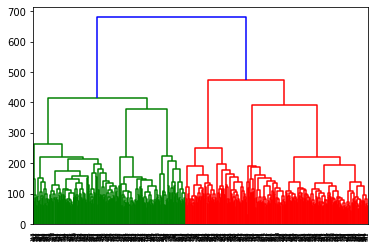

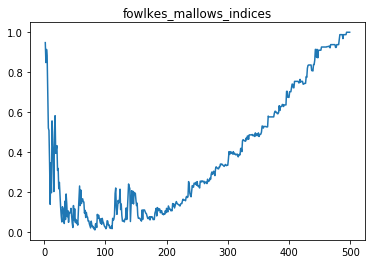

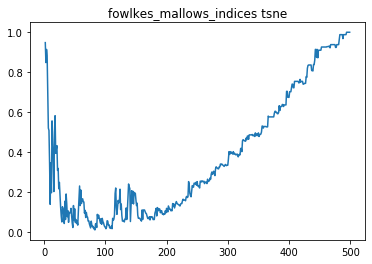

array([[-4.60791183e-01,  1.39256861e+00],
       [ 4.32551575e+00,  8.41041808e-01],
       [-3.36481682e+00, -4.51313326e-01],
       [-1.75884158e+00,  4.05488305e+00],
       [-3.71281701e+00, -9.31998428e-01],
       [-2.77837408e-01,  4.90470564e+00],
       [ 5.76264779e-01,  4.75911933e+00],
       [-2.27714577e+00, -5.48102891e-01],
       [-4.04159005e+00, -8.09273179e-01],
       [ 5.07359052e+00,  3.40681754e-01],
       [-4.35634619e+00,  4.92634655e-01],
       [ 1.23056582e+00,  4.97509044e+00],
       [-1.86523835e+00, -5.41184757e-01],
       [ 2.90782440e+00,  2.02056740e+00],
       [-7.64243922e-01,  2.67089223e+00],
       [-4.44623384e+00, -2.17376599e+00],
       [-4.67198245e+00, -2.00188642e+00],
       [-1.01560490e+00,  5.01926717e+00],
       [ 2.52319924e+00, -2.15279322e+00],
       [-4.53310123e+00, -2.01467795e+00],
       [ 1.36323014e+00, -5.26492614e+00],
       [ 1.30790572e+00, -9.35286425e-01],
       [ 1.78438683e-01,  2.94574381e+00],
       [ 3.

In [81]:
g_tsne(X,y, iterations = 500, save_name="image_net")

dumping pvals and partitions
Preprocessing done...


Iteration 10: error is 1795.789935
Iteration 20: error is 1781.671342
Iteration 30: error is 1741.858775
Iteration 40: error is 1676.275224
Iteration 50: error is 1620.374008
Iteration 60: error is 1580.021762
Iteration 70: error is 1547.503018
Iteration 80: error is 1519.678072
Iteration 90: error is 1495.451382
Iteration 100: error is 1473.338748
Iteration 110: error is 1452.549991
Iteration 120: error is 1433.249561
Iteration 130: error is 1415.673530
Iteration 140: error is 1399.764139
Iteration 150: error is 1385.320229
Iteration 160: error is 1372.140282
Iteration 170: error is 1360.061901
Iteration 180: error is 1348.948491
Iteration 190: error is 1338.670649
Iteration 200: error is 1329.103157
Iteration 210: error is 1320.134010
Iteration 220: error is 1311.673310
Iteration 230: error is 1303.654157
Iteration 240: error is 1296.026109
Iteration 250: error is 1288.746961
Iteration 260: error is 1281.777416
Iteration 270: error

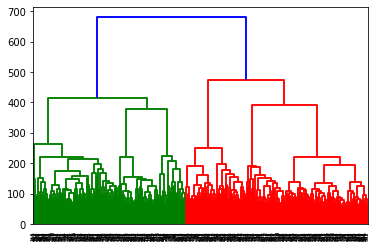

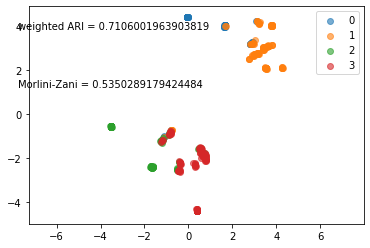

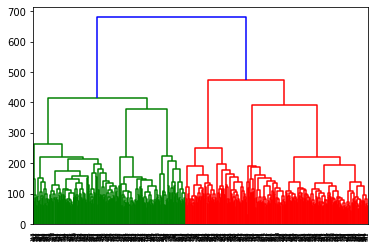

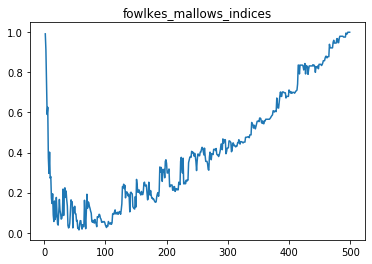

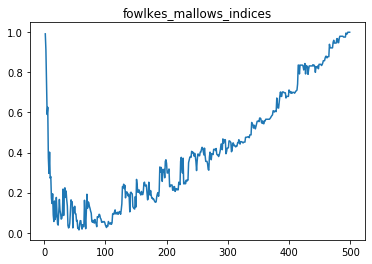

array([[-1.09981442e+00, -1.03021622e+00],
       [ 3.16728694e+00,  2.74675792e+00],
       [-1.73685827e+00, -2.39487233e+00],
       [-6.10120270e-02,  4.42591763e+00],
       [-3.51352643e+00, -5.75062260e-01],
       [-2.66776713e-02,  4.40636189e+00],
       [-2.73491068e-02,  4.39834527e+00],
       [-1.66900773e+00, -2.40813118e+00],
       [-3.53037524e+00, -5.62789607e-01],
       [ 4.24600563e+00,  2.11827847e+00],
       [-3.53083888e+00, -5.56745336e-01],
       [ 2.88808541e+00,  3.24735750e+00],
       [-1.65839893e+00, -2.42000281e+00],
       [ 2.96777396e+00,  2.69893082e+00],
       [ 1.64001332e+00,  4.00650913e+00],
       [-3.54170825e+00, -5.51600375e-01],
       [-3.53443645e+00, -5.57806172e-01],
       [-5.75806616e-02,  4.42241301e+00],
       [-3.27605490e-01, -2.26862803e+00],
       [-3.54002322e+00, -5.53225536e-01],
       [ 3.89006813e-01, -4.39762004e+00],
       [ 3.00553575e-01, -2.29731991e+00],
       [ 3.12226495e+00,  4.23438519e+00],
       [-1.

In [82]:
g_htsne(X,y, iterations = 500, save_name="image_net")

In [311]:
inet_tsne_result = np.loadtxt("./imagenet_4_clusters/image_net_y.csv",
                        delimiter=",")
inet_htsne_result = np.load("./imagenet_4_clusters/image_net_htsne_data.npy")




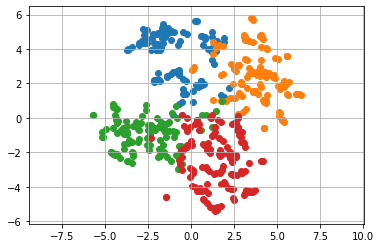

In [321]:
plot_blobs(inet_tsne_result, y)

In [277]:
print(dendrogram_norm(X, inet_tsne_result))

print(dendrogram_norm(X, inet_htsne_result))

      fun: 3687458.35438941
 hess_inv: array([[3.0917822e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([11.89975223])
3687458.35438941
      fun: 4727422.624582357
 hess_inv: array([[3.70120002e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([9.61942459])
4727422.624582357


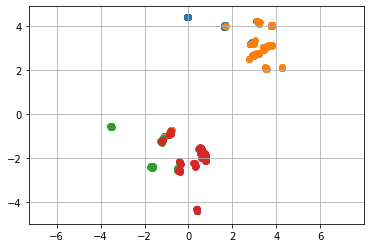

In [293]:
plot_blobs(inet_htsne_result, y)

Preprocessing done...


Iteration 100: error is 1.760182
Iteration 200: error is 1.618425


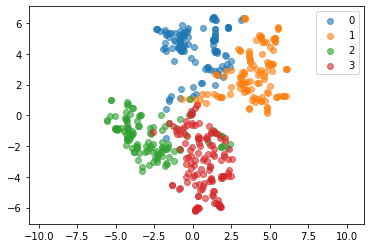

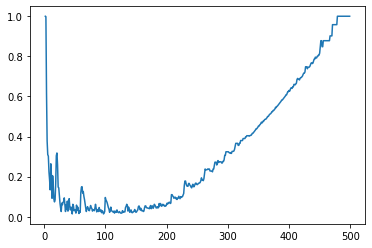

In [322]:
late_exagg_inet = modified_tsne(X, inet_htsne_result, y, iterations=200)

In [320]:
print(dendrogram_norm(X, late_exagg_inet))

      fun: 3907837.955382156
 hess_inv: array([[2.8162135e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([10.79677447])
3907837.955382156


In [88]:
tsne_x = np.loadtxt("./3_blob_2_close_1_far/3_blob_2_close_1_far_500_pts_y.csv", delimiter = ",")

In [93]:
htsne_x = np.load("./3_blob_2_close_1_far/3_blob_2_close_1_far_500_pts_htsne_data.npy")

In [91]:
from hierarchy import fowlkes_mallows_indices

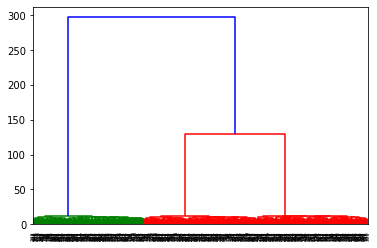

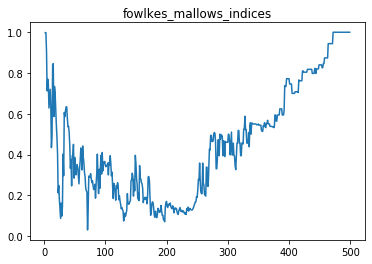

NameError: name 'save_name' is not defined

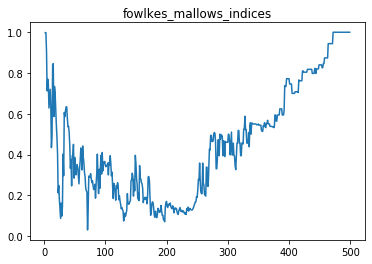

In [92]:
ixds = fowlkes_mallows_indices(X, tsne_x)
plt.figure()
plt.title("fowlkes_mallows_indices")
plt.plot(list(ixds.keys()), list(ixds.values()))
if (save_name is not None):
    plt.savefig(save_name + '_fm_idx_htsne.png')
plt.show()

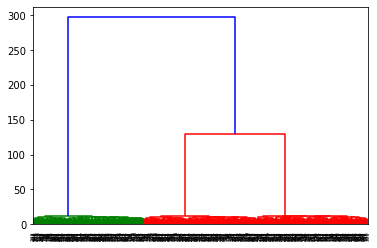

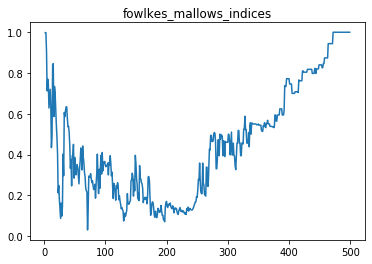

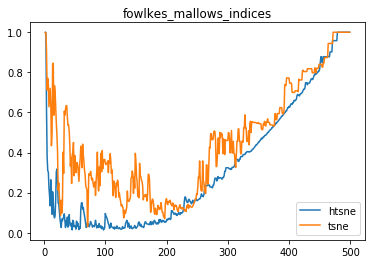

In [95]:
ixds = fowlkes_mallows_indices(X, htsne_x)
ixds2 = fowlkes_mallows_indices(X, tsne_x)

plt.figure()
plt.title("fowlkes_mallows_indices")
plt.plot(list(ixds.keys()), list(ixds.values()), label="htsne")
plt.plot(list(ixds2.keys()), list(ixds2.values()), label="tsne")
plt.legend()
plt.show()

array([8.95098995e-03, 7.81956538e-01, 7.16868165e-03, 6.17536870e-03,
       3.10533811e-02, 8.78037553e-03, 2.11141576e-03, 4.48194176e-02,
       6.96259258e-03, 2.73832098e-03, 1.34299070e-02, 2.98713660e-03,
       5.70223049e-03, 6.62964006e-03, 5.21850150e-03, 2.42143169e-03,
       6.06278169e-03, 2.73156091e-04, 3.55307106e-03, 7.56619501e-03,
       1.17165062e-03, 8.38516874e-04, 1.32885408e-04, 1.00019009e-04,
       5.37305271e-04, 4.19907777e-03, 1.35791077e-04, 1.01108888e-03,
       2.73981606e-03, 7.71380324e-04, 1.58277864e-05, 1.49661813e-03,
       6.83003064e-05, 8.19938323e-04, 8.21314939e-04, 4.61449561e-04,
       1.73677668e-04, 2.64491850e-03, 3.50031071e-04, 7.26743292e-04,
       1.09047709e-03, 2.21598169e-03, 1.16427071e-03, 3.76297496e-04,
       1.27322211e-04, 4.34957510e-04, 7.65500387e-04, 1.01107334e-04,
       3.13565067e-04, 1.86003970e-04, 8.34872651e-05, 1.61942546e-04,
       6.64825729e-04, 1.70752408e-04, 2.06669686e-04, 6.76242108e-04,
      

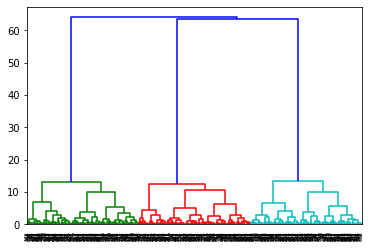

In [96]:
get_dendrogram_weights(tsne_x)

array([7.24688318e-01, 2.64315478e-01, 1.11488452e-03, 4.18703750e-03,
       1.20415412e-03, 1.20545462e-03, 1.80201241e-04, 2.87957574e-04,
       8.02416834e-04, 1.89378121e-04, 1.29174471e-04, 2.28278617e-04,
       1.62597126e-04, 2.47760896e-04, 1.61928617e-04, 3.51255715e-05,
       2.40569082e-06, 1.61887730e-05, 2.41072787e-05, 1.86682655e-05,
       9.14799160e-05, 1.01933180e-04, 6.39405806e-05, 2.06371702e-05,
       4.17993082e-05, 3.89625297e-05, 1.54296555e-05, 1.24089749e-05,
       2.13948162e-05, 1.78837562e-05, 1.24440312e-06, 4.80050339e-07,
       2.04310283e-05, 3.28219428e-05, 2.00117782e-08, 1.34770487e-05,
       7.96877255e-06, 1.42864239e-06, 3.20030385e-05, 4.57764366e-06,
       4.54848065e-06, 1.74731391e-05, 1.85170933e-05, 1.27095146e-05,
       7.88467471e-06, 6.07327939e-07, 7.62232620e-06, 1.65632553e-05,
       1.97843320e-06, 8.16523881e-06, 8.77709588e-07, 5.16358868e-06,
       5.48453185e-06, 1.43153339e-06, 3.45346690e-06, 9.51700950e-06,
      

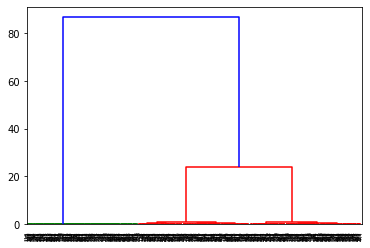

In [97]:
get_dendrogram_weights(htsne_x)

In [117]:
import numpy as np
from sklearn import metrics
import scipy
import math
from scipy.cluster import hierarchy
import itertools

def get_linkage(X):
    ytdist = distance.pdist(X, metric = 'euclidean')
    Z = hierarchy.linkage(ytdist, 'ward')
    return Z

# icoord = scipy.array(dn['icoord'])
# dcoord = scipy.array(dn['dcoord'])
# x = sorted(list(zip(dn['dcoord'])), key = lambda x: x[0][1], reverse = True)
# #    print((x))
# height = x[0][0][1]
# weights = []
# x.append(([0,0,0,0],))
# while len(x) > 1:
# #        print(x[0])
#     weights.append(x[0][0][1] - x[1][0][1])
#     x.pop(0)
# #        print(len(x))
# weights = weights / height

In [118]:
tsne_linkage = get_linkage(tsne_x)

In [119]:
htsne_linkage = get_linkage(htsne_x)
original_linkage = get_linkage(X)

In [120]:
from scipy import optimize


In [146]:
func = lambda alpha: np.linalg.norm(original_linkage[:,2] - alpha * htsne_linkage[:,2]) **2
func2 = lambda alpha: np.linalg.norm(original_linkage[:,2] - alpha * tsne_linkage[:,2]) **2

In [147]:
optimize.minimize(func, x0=5)

      fun: 26459.56297944045
 hess_inv: array([[6.16054394e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([3.57280989])

In [148]:
func(3.57280989)

26459.56297944045

In [149]:
optimize.minimize(func2, x0=5)

      fun: 33991.11112702317
 hess_inv: array([[5.28691271e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([3.187223])

In [150]:
diff_htsne = original_linkage[:,2] - 3.57280989 * htsne_linkage[:,2]

In [151]:
diff_tsne=original_linkage[:,2] - 3.187223 * tsne_linkage[:,2]

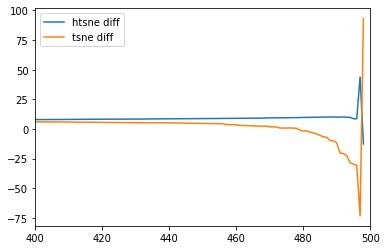

In [159]:
plt.plot(np.abs(diff_htsne), label="htsne diff")
plt.plot(np.abs(diff_tsne), label="tsne diff")
plt.xlim(400,500)
plt.legend()
plt.show()

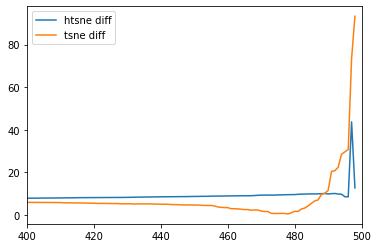

In [160]:
plt.plot(np.abs(diff_htsne), label="htsne diff")
plt.plot(np.abs(diff_tsne), label="tsne diff")
plt.xlim(400,500)
plt.legend()
plt.show()

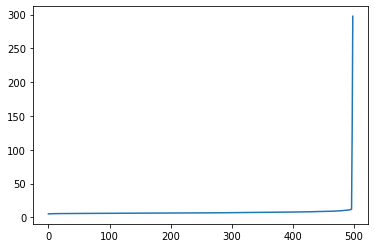

In [158]:
plt.plot(original_linkage[:,2])

<module 'scipy.cluster.hierarchy' from '/home/mstrals/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py'>

In [173]:
from hierarchy import dendrogram_norm

In [172]:
reload(hierarchy)

<module 'hierarchy' from '/home/mstrals/MSTER-ALS-Matrix-Factorization/tsne/hierarchy.py'>

In [178]:
dendrogram_norm(X,htsne_x)

26459.562979440438

In [323]:
import keras


In [381]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [382]:
x_train = np.reshape(x_train, (-1, 784))


In [336]:
X = x_train[indices]

In [337]:
y = y_train[indices]

array([3.33154211e-02, 9.68121804e-02, 5.75592550e-02, 8.59893458e-02,
       9.53523617e-02, 5.05506137e-02, 2.16014137e-02, 5.47155947e-03,
       3.93370328e-03, 6.23569468e-03, 6.80866238e-03, 1.22317577e-02,
       9.99315046e-03, 3.26644407e-02, 4.17243574e-02, 2.36818067e-04,
       4.58679686e-03, 1.28295420e-02, 1.83783391e-02, 2.06546508e-02,
       2.77409093e-03, 7.89398970e-03, 1.17104610e-02, 8.90904132e-04,
       1.82619304e-03, 6.20424180e-03, 1.28599141e-02, 4.34504397e-03,
       1.11728432e-03, 5.96186644e-03, 2.23648804e-03, 3.60451336e-03,
       1.69864495e-03, 9.09886316e-04, 5.56058328e-03, 2.83556266e-03,
       1.11548153e-02, 4.14702385e-03, 1.68778196e-03, 1.47649077e-03,
       6.55899663e-04, 4.67630880e-03, 1.11323545e-03, 2.64701431e-04,
       9.80390603e-04, 2.50733266e-03, 1.10519580e-02, 1.34796513e-03,
       4.82727658e-04, 3.60015401e-03, 1.32173301e-03, 2.85797882e-03,
       1.70434206e-03, 3.87354774e-03, 1.18107653e-04, 9.15688534e-04,
      

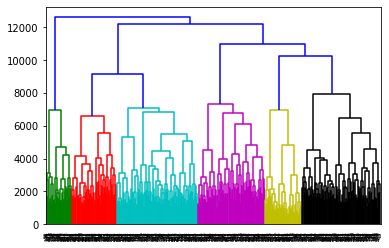

In [331]:
get_dendrogram_weights(X)

Preprocessing done...


Iteration 100: error is 17.495792
Iteration 200: error is 2.307778
Iteration 300: error is 2.028906
Iteration 400: error is 1.860362
Iteration 500: error is 1.743553
Weighted Adjusted Rand Index: 0.6020550331021166
Morlini-Zani Index: 0.49941949773737154


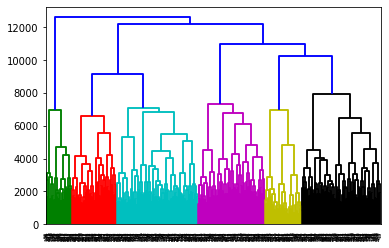

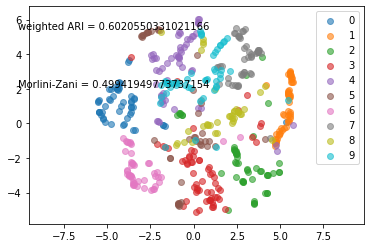

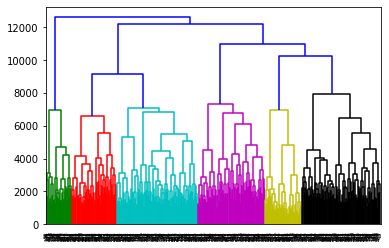

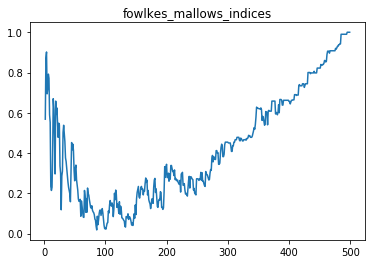

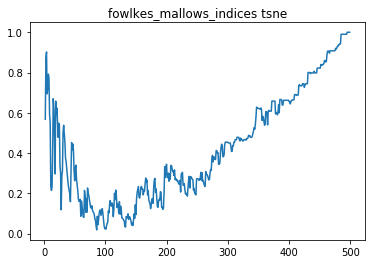

In [332]:
tsne_x = g_tsne(X,y, save_name="mnist_500_pts", iterations=500)

dumping pvals and partitions
Preprocessing done...


Iteration 10: error is 1861.761335
Iteration 20: error is 1853.012962
Iteration 30: error is 1833.514570
Iteration 40: error is 1793.602186
Iteration 50: error is 1736.750953
Iteration 60: error is 1682.539873
Iteration 70: error is 1639.827455
Iteration 80: error is 1605.466835
Iteration 90: error is 1575.700610
Iteration 100: error is 1548.108687
Iteration 110: error is 1521.397737
Iteration 120: error is 1495.207981
Iteration 130: error is 1469.818761
Iteration 140: error is 1445.722867
Iteration 150: error is 1423.384946
Iteration 160: error is 1403.131657
Iteration 170: error is 1384.991278
Iteration 180: error is 1368.720036
Iteration 190: error is 1353.969718
Iteration 200: error is 1340.408597
Iteration 210: error is 1327.773285
Iteration 220: error is 1315.881132
Iteration 230: error is 1304.620429
Iteration 240: error is 1293.930227
Iteration 250: error is 1283.779864
Iteration 260: error is 1274.153431
Iteration 270: error

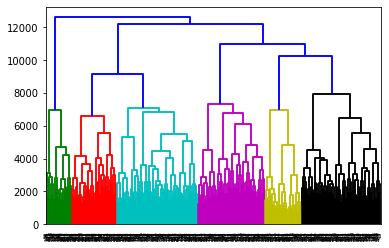

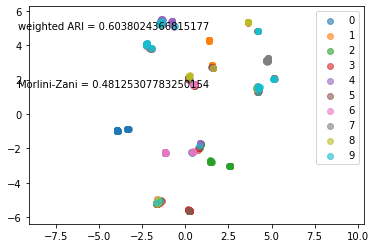

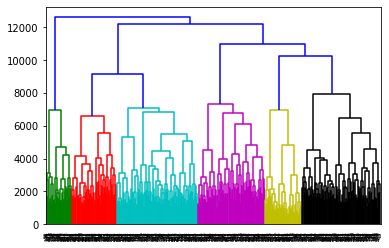

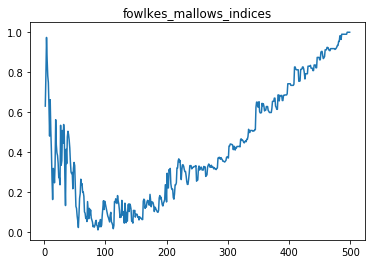

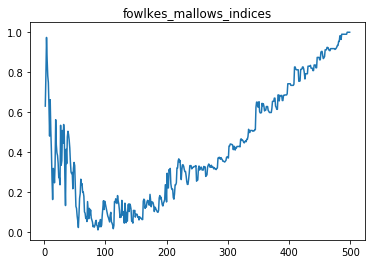

In [333]:
htsne_x = g_htsne(X,y, save_name="mnist_500_pts", iterations=500)

Preprocessing done...


Iteration 100: error is 1.836204


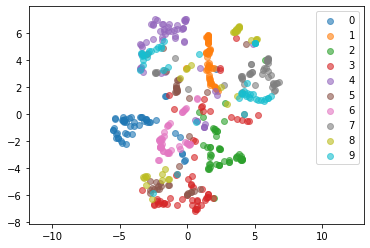

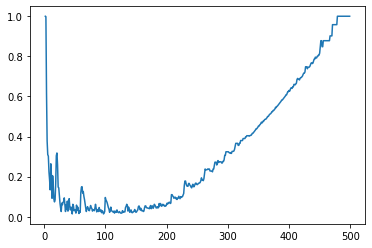

In [365]:
late_exaggerated = modified_tsne(X, htsne_x, y, iterations = 150)

In [356]:
print(dendrogram_norm(X, tsne_x))

print(dendrogram_norm(X, htsne_x))


      fun: 1963099154.3566878
 hess_inv: array([[2.86447767e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 2
     njev: 6
   status: 0
  success: True
        x: array([285.563994])
1963099154.3566878
      fun: 2585426869.5998945
 hess_inv: array([[2.58170903e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([203.37977667])
2585426869.5998945


array([8.95700278e-02, 3.41311731e-01, 2.84304096e-03, 4.46112034e-01,
       2.10086184e-03, 2.70977264e-03, 1.50233310e-02, 3.05503637e-03,
       2.33552864e-02, 3.57330003e-03, 1.78776794e-03, 1.02465649e-02,
       8.91373473e-03, 1.01854136e-03, 1.79643836e-03, 3.07438624e-03,
       1.05318137e-03, 1.30381759e-03, 5.69058690e-03, 1.96563823e-04,
       2.06243840e-03, 6.50149963e-04, 1.96628769e-03, 1.24196626e-03,
       3.16864942e-04, 4.86588769e-04, 1.50263417e-03, 1.47455722e-04,
       1.26793659e-03, 5.71338268e-06, 2.06773469e-04, 1.51999484e-03,
       1.05967277e-03, 2.44260242e-04, 1.61571218e-04, 7.25687838e-04,
       1.18733066e-03, 7.67461645e-04, 5.75677469e-04, 9.50511549e-04,
       3.56675461e-04, 4.02731455e-05, 8.42006329e-05, 5.45441313e-04,
       4.10349309e-05, 1.55879006e-04, 9.07630744e-04, 9.25307994e-04,
       9.73215315e-04, 1.20555179e-04, 1.80231894e-05, 3.04284470e-04,
       1.69394442e-04, 2.81117123e-04, 3.08117744e-04, 1.93450799e-05,
      

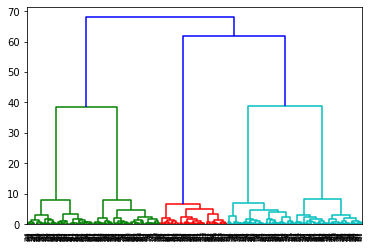

In [352]:
get_dendrogram_weights(tsne_result)

array([4.64390251e-01, 1.59349174e-01, 2.18970721e-02, 7.41676804e-02,
       5.01955716e-02, 5.47641548e-02, 1.03520463e-03, 7.94215019e-03,
       7.22948900e-03, 3.20432286e-02, 9.61128856e-04, 2.59283920e-03,
       5.14039202e-02, 2.12071482e-03, 2.89102621e-03, 2.26007923e-03,
       1.42085753e-04, 3.63685298e-03, 2.01530565e-03, 1.72438928e-04,
       8.12820724e-03, 3.23160849e-04, 1.74869078e-03, 4.92636889e-06,
       5.17211783e-04, 4.48303309e-03, 1.74081751e-03, 2.95935600e-04,
       1.96515709e-03, 1.53481762e-03, 2.11951279e-04, 5.09533687e-04,
       1.59042694e-03, 1.27976247e-03, 1.62187926e-04, 1.01552054e-04,
       2.48794792e-03, 2.36656398e-03, 4.34897034e-04, 3.43894004e-03,
       3.40923418e-04, 1.51635389e-04, 9.29027797e-04, 7.59397542e-05,
       4.05247319e-04, 7.28641776e-04, 8.55868377e-04, 9.84963264e-05,
       5.61531074e-04, 2.62720997e-04, 2.21321108e-04, 4.17496216e-04,
       6.57015213e-04, 9.48854794e-04, 3.77346558e-04, 1.79899147e-03,
      

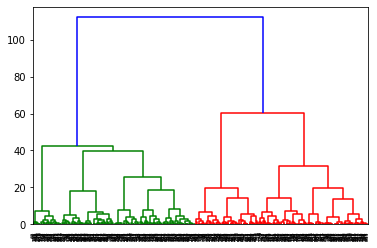

In [366]:
get_dendrogram_weights(late_exaggerated)

array([3.33154211e-02, 9.68121804e-02, 5.75592550e-02, 8.59893458e-02,
       9.53523617e-02, 5.05506137e-02, 2.16014137e-02, 5.47155947e-03,
       3.93370328e-03, 6.23569468e-03, 6.80866238e-03, 1.22317577e-02,
       9.99315046e-03, 3.26644407e-02, 4.17243574e-02, 2.36818067e-04,
       4.58679686e-03, 1.28295420e-02, 1.83783391e-02, 2.06546508e-02,
       2.77409093e-03, 7.89398970e-03, 1.17104610e-02, 8.90904132e-04,
       1.82619304e-03, 6.20424180e-03, 1.28599141e-02, 4.34504397e-03,
       1.11728432e-03, 5.96186644e-03, 2.23648804e-03, 3.60451336e-03,
       1.69864495e-03, 9.09886316e-04, 5.56058328e-03, 2.83556266e-03,
       1.11548153e-02, 4.14702385e-03, 1.68778196e-03, 1.47649077e-03,
       6.55899663e-04, 4.67630880e-03, 1.11323545e-03, 2.64701431e-04,
       9.80390603e-04, 2.50733266e-03, 1.10519580e-02, 1.34796513e-03,
       4.82727658e-04, 3.60015401e-03, 1.32173301e-03, 2.85797882e-03,
       1.70434206e-03, 3.87354774e-03, 1.18107653e-04, 9.15688534e-04,
      

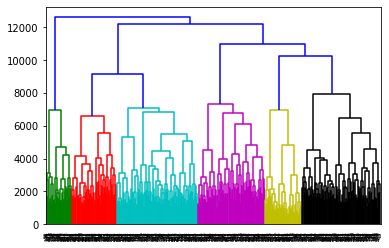

In [367]:
get_dendrogram_weights(X)

array([5.30381915e-01, 1.17715872e-01, 6.71430761e-02, 4.81181258e-03,
       1.10387204e-01, 2.20159758e-02, 2.99324563e-02, 1.05264884e-02,
       9.10841993e-03, 9.70613008e-03, 7.66954781e-03, 1.73987006e-03,
       3.39984549e-02, 4.62621691e-04, 1.79903313e-02, 2.40231946e-03,
       9.12776596e-04, 3.12058533e-04, 2.31018400e-03, 9.09949862e-03,
       3.58847002e-03, 6.05420798e-04, 5.42087458e-04, 6.49716301e-04,
       5.90978660e-04, 6.81648322e-04, 7.03266839e-05, 4.95052906e-05,
       1.40095927e-03, 3.27130616e-04, 3.72458046e-05, 2.34223872e-04,
       9.37459277e-06, 9.49021849e-05, 2.08045240e-04, 9.76504794e-06,
       1.12486281e-05, 1.08495384e-05, 7.29874199e-05, 6.74617008e-05,
       1.00983026e-07, 9.60297379e-05, 1.03452911e-04, 3.68952563e-05,
       1.52919471e-04, 1.09512859e-05, 1.63128909e-05, 1.14588049e-04,
       1.93281004e-06, 4.87809870e-05, 2.14600484e-05, 4.50349874e-05,
       4.84726963e-05, 1.62923701e-05, 1.43337068e-05, 8.22860506e-05,
      

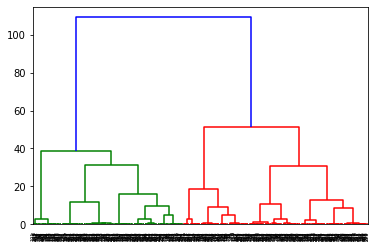

In [368]:
get_dendrogram_weights(htsne_x)

In [358]:
print(dendrogram_norm(X, late_exaggerated))


      fun: 2128046555.9351952
 hess_inv: array([[1.61511397e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 8
   status: 0
  success: True
        x: array([227.46133612])
2128046555.9351952


array([5.30381915e-01, 1.17715872e-01, 6.71430761e-02, 4.81181258e-03,
       1.10387204e-01, 2.20159758e-02, 2.99324563e-02, 1.05264884e-02,
       9.10841993e-03, 9.70613008e-03, 7.66954781e-03, 1.73987006e-03,
       3.39984549e-02, 4.62621691e-04, 1.79903313e-02, 2.40231946e-03,
       9.12776596e-04, 3.12058533e-04, 2.31018400e-03, 9.09949862e-03,
       3.58847002e-03, 6.05420798e-04, 5.42087458e-04, 6.49716301e-04,
       5.90978660e-04, 6.81648322e-04, 7.03266839e-05, 4.95052906e-05,
       1.40095927e-03, 3.27130616e-04, 3.72458046e-05, 2.34223872e-04,
       9.37459277e-06, 9.49021849e-05, 2.08045240e-04, 9.76504794e-06,
       1.12486281e-05, 1.08495384e-05, 7.29874199e-05, 6.74617008e-05,
       1.00983026e-07, 9.60297379e-05, 1.03452911e-04, 3.68952563e-05,
       1.52919471e-04, 1.09512859e-05, 1.63128909e-05, 1.14588049e-04,
       1.93281004e-06, 4.87809870e-05, 2.14600484e-05, 4.50349874e-05,
       4.84726963e-05, 1.62923701e-05, 1.43337068e-05, 8.22860506e-05,
      

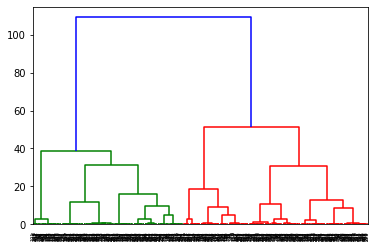

In [355]:
get_dendrogram_weights(htsne_x)

In [369]:
np.array([0,1]) * np.array([2,3])

array([0, 3])

In [383]:
X_mnist = x_train[indices[:300]]

y_mnist = y_train[indices[:300]]

Preprocessing done...


Iteration 100: error is 15.417204
Iteration 200: error is 1.698589
Iteration 300: error is 1.452107
Iteration 400: error is 1.317522
Iteration 500: error is 1.228928
Weighted Adjusted Rand Index: 0.5881647114638977
Morlini-Zani Index: 0.4752395514567615


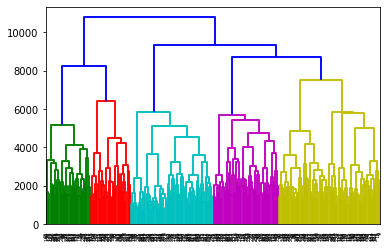

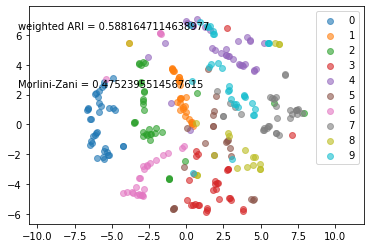

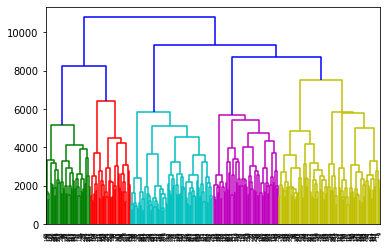

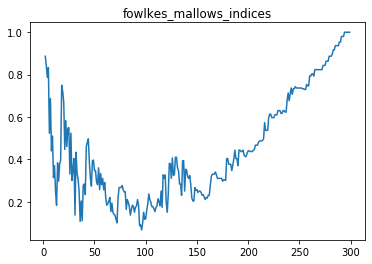

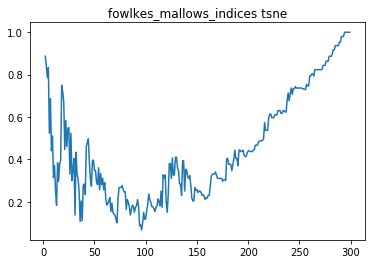

In [384]:
mnist_300_tsne = g_tsne(X_mnist, y_mnist)

In [391]:
gamma = np.linspace(10,1,len(X_mnist) - 1)
gamma = gamma / sum(gamma)
gamma = gamma * len(X_mnist)

dumping pvals and partitions
Preprocessing done...


Iteration 10: error is 957.203142
Iteration 20: error is 951.152445
Iteration 30: error is 942.635459
Iteration 40: error is 930.732017
Iteration 50: error is 915.302588
Iteration 60: error is 897.044578
Iteration 70: error is 876.853967
Iteration 80: error is 855.546284
Iteration 90: error is 834.022817
Iteration 100: error is 813.226838
Iteration 110: error is 793.721780
Iteration 120: error is 775.540228
Iteration 130: error is 758.502048
Iteration 140: error is 742.538422
Iteration 150: error is 727.771736
Iteration 160: error is 714.229143
Iteration 170: error is 701.766584
Iteration 180: error is 690.250742
Iteration 190: error is 679.602958
Iteration 200: error is 669.757983
Iteration 210: error is 660.641059
Iteration 220: error is 652.176860
Iteration 230: error is 644.300596
Iteration 240: error is 636.954722
Iteration 250: error is 630.079954
Iteration 260: error is 623.611879
Iteration 270: error is 617.485559
Iteration 2

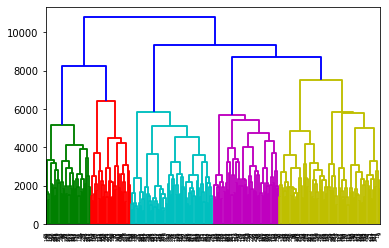

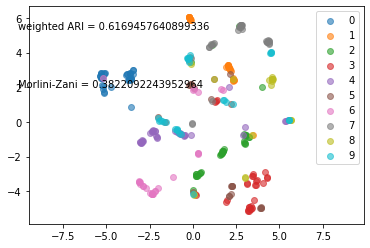

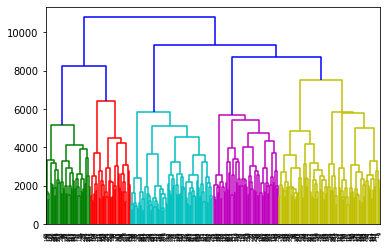

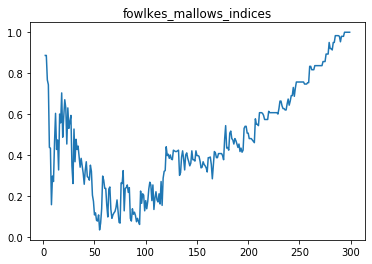

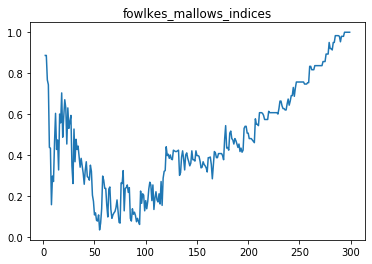

In [394]:
mnist_300_htsne = g_htsne(X_mnist, y_mnist, gamma=gamma)

array([1.35154274e-01, 5.52591087e-02, 4.80926281e-02, 6.32575140e-02,
       1.05114923e-01, 4.96971253e-02, 2.04125947e-03, 6.07105395e-03,
       7.04424044e-03, 2.73305603e-02, 2.12247091e-02, 3.28708057e-03,
       1.12093898e-02, 1.33794408e-02, 1.27183610e-02, 1.81713863e-02,
       2.74139862e-03, 1.84826015e-02, 8.30792068e-03, 5.25848549e-03,
       3.47110374e-03, 1.02247455e-02, 2.28377633e-03, 9.29750041e-03,
       1.53692425e-02, 3.45439902e-03, 4.05499571e-03, 2.03443779e-03,
       3.07487501e-03, 1.17917958e-02, 5.15891567e-03, 3.97801025e-03,
       4.58523687e-03, 2.18556103e-03, 4.11186778e-03, 2.55713720e-04,
       7.32294441e-04, 1.30552211e-03, 4.70614778e-03, 5.10997270e-04,
       1.64923299e-03, 2.72138961e-03, 1.65881479e-03, 2.37751330e-03,
       5.15204676e-03, 9.33565939e-04, 5.52152881e-03, 7.52457051e-04,
       1.81174821e-03, 1.07978935e-04, 8.42793306e-04, 6.71322554e-03,
       1.13509218e-03, 3.20993842e-03, 1.39160832e-03, 1.70110794e-06,
      

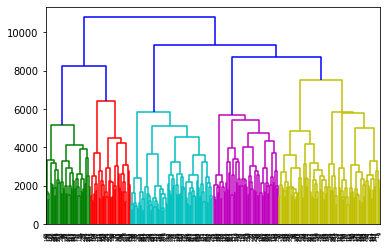

In [395]:
get_dendrogram_weights(X_mnist)

array([2.19009973e-01, 3.02145357e-01, 5.41772641e-02, 6.71916593e-02,
       1.00400242e-01, 1.38803020e-02, 2.82568828e-02, 1.51238207e-02,
       2.30284213e-02, 9.13685889e-03, 1.04335888e-02, 2.27288572e-02,
       6.32826981e-03, 1.18778627e-02, 8.65295018e-03, 6.10675770e-03,
       6.42753768e-03, 1.68374846e-02, 2.83736637e-03, 3.81116203e-03,
       9.87105531e-04, 5.05215500e-03, 9.07431648e-04, 1.76713543e-03,
       2.31892498e-03, 4.96915302e-03, 9.52225366e-04, 9.14007091e-04,
       2.97029913e-04, 4.03515921e-04, 1.67437096e-03, 4.69165092e-05,
       1.07798594e-04, 8.46932675e-03, 2.14153420e-04, 5.19851354e-03,
       3.56270882e-04, 1.86196413e-04, 2.16123363e-05, 2.95001148e-04,
       3.73263253e-04, 1.03490837e-03, 3.86248631e-05, 2.89462790e-03,
       8.21069157e-04, 1.86261585e-03, 4.96659862e-04, 1.93445899e-03,
       4.50917810e-04, 2.03489944e-03, 2.07608514e-04, 1.40242250e-04,
       6.51136644e-04, 1.64006387e-04, 4.77840346e-04, 1.70574994e-04,
      

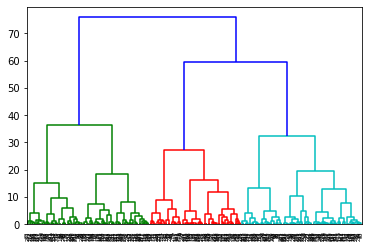

In [398]:
get_dendrogram_weights(mnist_300_tsne)

array([1.06357854e-01, 2.85117075e-01, 2.76142218e-01, 2.89390656e-02,
       2.85668499e-05, 2.34844226e-02, 8.63698624e-02, 4.93094948e-03,
       2.96488379e-02, 2.61595841e-02, 1.08893585e-02, 2.14202742e-03,
       1.28451396e-02, 3.28342287e-04, 9.03168349e-03, 7.81949253e-03,
       3.08581886e-03, 2.21078825e-03, 1.22940090e-02, 6.31939938e-03,
       1.30451775e-04, 2.05089337e-02, 2.26994850e-03, 2.73983977e-03,
       1.59736839e-04, 1.22167981e-03, 3.05385540e-03, 4.88764147e-03,
       7.61457882e-04, 1.04845788e-04, 3.36881093e-03, 7.73437045e-04,
       1.30632539e-03, 1.09224084e-03, 1.05981293e-04, 3.11810993e-03,
       4.16826660e-04, 2.40566218e-04, 6.52681923e-04, 2.62226196e-03,
       2.21074336e-03, 2.90845844e-05, 1.49414925e-03, 7.68133788e-05,
       7.33921372e-05, 7.51344745e-04, 2.13409204e-04, 8.13489719e-05,
       1.48070359e-04, 2.75409316e-04, 2.56569037e-04, 4.81740785e-04,
       1.57962969e-04, 1.77114396e-04, 6.63087511e-04, 1.87539784e-04,
      

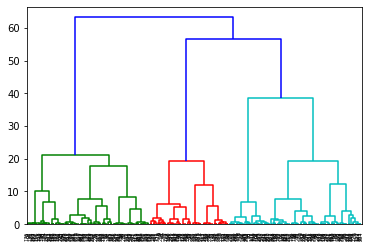

In [399]:
get_dendrogram_weights(mnist_300_htsne)

Preprocessing done...


Iteration 100: error is 1.389928
Iteration 200: error is 1.315955


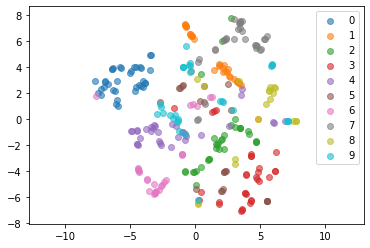

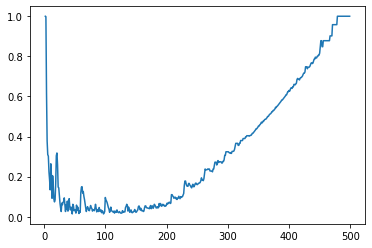

In [406]:
late_exaggerated_mnist = modified_tsne(X_mnist, mnist_300_htsne, y_mnist, iterations = 200)

In [407]:
dendrogram_norm(X_mnist, late_exaggerated_mnist)


      fun: 1153854602.3807344
 hess_inv: array([[2.88094601e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 3
     njev: 8
   status: 0
  success: True
        x: array([226.60761931])


1153854602.3807344

In [408]:
dendrogram_norm(X_mnist, mnist_300_tsne)


      fun: 1143192909.8131034
 hess_inv: array([[3.3127051e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 3
     njev: 8
   status: 0
  success: True
        x: array([244.4443457])


1143192909.8131034

In [409]:
dendrogram_norm(X_mnist, mnist_300_htsne)

      fun: 1309860918.6951177
 hess_inv: array([[4.49679932e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 3
     njev: 7
   status: 0
  success: True
        x: array([257.14109554])


1309860918.6951177

In [ ]:
# datasets: 20 news group bag of words
# tree preserving embedding dataset for proteins
# some other multilevel datasets
# 